In [238]:
import planarity
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
import numpy as np

%matplotlib inline

## Hello Networkx and Planarity


[NetworkX Homepage](https://networkx.github.io/)

[Planarity's Github Page](https://github.com/hagberg/planarity)

The graph is  planar


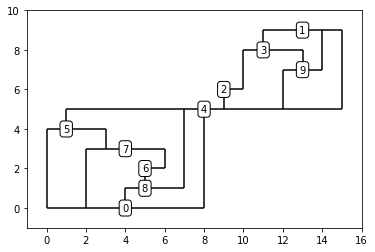

In [11]:
# generate random graph
G = nx.generators.fast_gnp_random_graph(10, 0.4)
# check planarity and draw the graph
print("The graph is {0} planar".format("" if planarity.is_planar(G) else "not"))
if(planarity.is_planar(G)):
    planarity.draw(G)

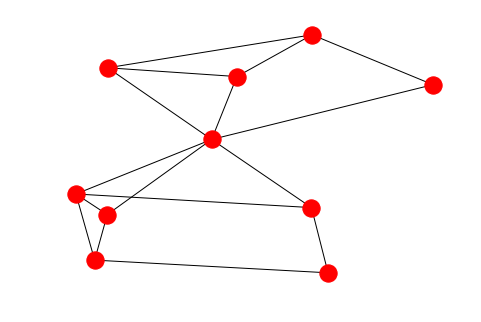

In [12]:
nx.draw(G)

# Naïve Database creator script

In [265]:
# for the sake of this experiment, I'd used a fix 32x32 grid for adjacency matrix. This is a huge assumption, but this is just a stupid test!

def create_db():
    # create empty list
    planar_list = []
    non_planar_list = []
    
    # generate random graphs and store their adjacency lists
    for p in range(1, 95):
        for _ in range(50000):
            G = nx.generators.fast_gnp_random_graph(32, p/100.0)
            if planarity.is_planar(G):
                planar_list.append(nx.to_numpy_array(G))
            else:
                if(len(planar_list) > len(non_planar_list)):
                    non_planar_list.append(nx.to_numpy_array(G))

    # let see how many graph we've got
    print(len(planar_list))
    print(len(non_planar_list))
    
    
    # save planar graphs as numpy nd-array
    planar_db = np.array(planar_list)
    np.save("planar_db.npy", planar_db)

    # save non planar graphs as numpy nd-array
    non_planar_db = np.array(non_planar_list)
    np.save("not_planar_db.npy", non_planar_db)

## Create a new database or load one!

In [2]:
planar_db = np.load("planar_db.npy")
non_planar_db = np.load("not_planar_db.npy")

np.random.shuffle(planar_db)
np.random.shuffle(non_planar_db)

all_data = np.append(planar_db, non_planar_db, axis=0)
all_labels = np.append(np.ones(len(planar_db)), np.zeros(len(non_planar_db))).astype(int)

In [4]:
# shuffling ...
permutation = np.random.permutation(all_data.shape[0])
all_data = all_data[permutation]
all_labels = all_labels[permutation]

In [5]:
training_set = all_data[:250000] 
training_label = all_labels[:250000]

test_set = all_data[250000:] 
test_label = all_labels[250000:] 

## Create a Simple ConvNet using PyTorch

In [236]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net
# Let's go CUDA!
net.cuda()

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 2)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [83]:
running_loss = 0.0
batch_size = 5000
train_size = training_set.shape[0]
batch_in_epoch = int(train_size/batch_size) + 1

for epoch in range(500):
    
    for i in range(batch_in_epoch):
        
        batch_data = training_set[i*batch_size: (i+1)*batch_size] 
        if(batch_data.shape[0] == 0):
            continue;
            
        batch_data = torch.from_numpy(training_set[i*batch_size: (i+1)*batch_size]).float().unsqueeze_(1)
        batch_label = torch.from_numpy(training_label[i*batch_size: (i+1)*batch_size]).long()
    
        inputs, labels = Variable(batch_data.cuda()), Variable(batch_label.cuda())
    
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [244]:
test_tensor = torch.from_numpy(test_set).float().unsqueeze_(1)

In [245]:
output = net(Variable(test_tensor.cuda()))
_, predicted = torch.max(output.data, 1)

In [246]:
predicted = predicted.cpu().numpy()
correct = (predicted == batch_test_label).sum()

In [247]:
print("prediction accuracy is {0}".format(correct / test_label.size))

prediction accuracy is 0.9544492023904757


In [255]:
wrong_predictions = test_set[predicted != batch_test_label]

## Let's plot some graphs that our ConvNet failed to classify correctly!

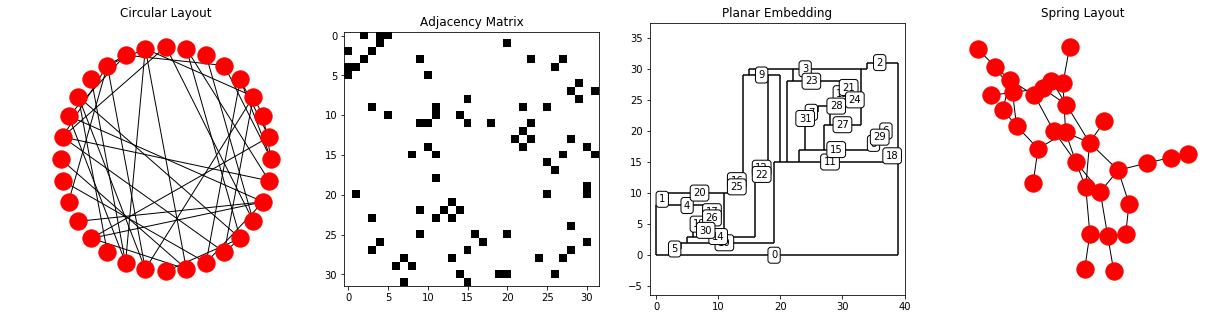

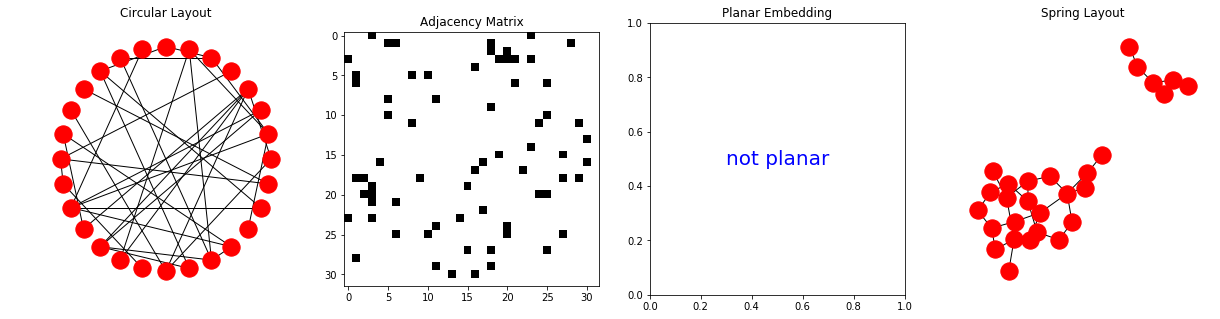

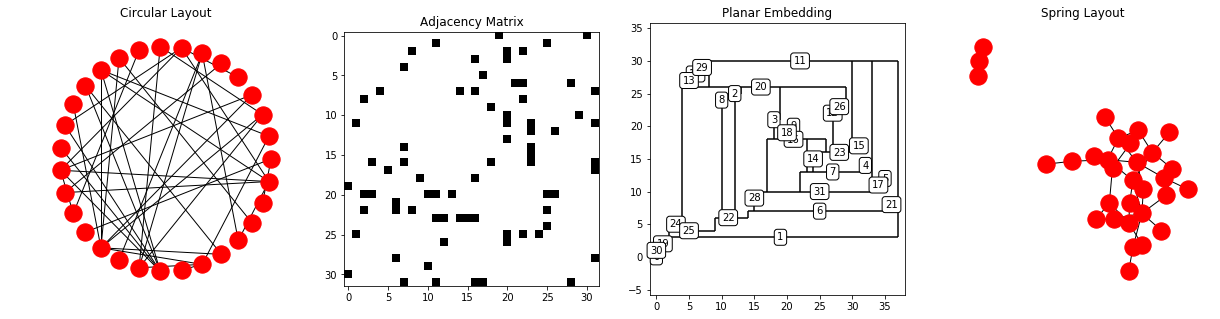

In [264]:
samples = np.random.choice(len(wrong_predictions), 3)

for i in samples:
    
    G = nx.from_numpy_matrix(wrong_predictions[i])
    isolated_edges = list(nx.isolates(G))
    G.remove_nodes_from(isolated_edges) 

    plt.figure(figsize=(21, 5))

    plt.subplot(1, 4, 1)
    nx.draw(G, pos=nx.circular_layout (G) )
    plt.title("Circular Layout")
    plt.draw()
    plt.subplot(1, 4, 2)
    plt.imshow(wrong_predictions[i], cmap='Greys', interpolation='nearest')
    plt.title("Adjacency Matrix")
    plt.subplot(1, 4, 3)
    if(planarity.is_planar(G)):
        planarity.draw(G)
    else:
        plt.text(0.5, 0.5, 
         'not planar', 
         ha='center', va='center',
         fontsize=20, 
         color="b")
    plt.title("Planar Embedding")   
    plt.subplot(1, 4, 4)
    nx.draw(G, pos=nx.spring_layout (G) )
    plt.draw()
    plt.title("Spring Layout")
    plt.show()